In [1]:
using StatsBase

In [2]:
include("betaSkeletons.jl")

plotDelaunay (generic function with 1 method)

In [3]:
using HDF5, JLD, Test, ProgressMeter, Pkg

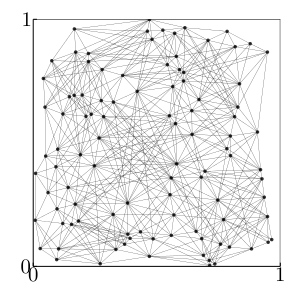

In [4]:
puntos, adeacencia = betaSkeleton(0.58, 100)
plotBetaSkeleton(puntos, adeacencia)

### Just for eigenvalues and $0<\beta_s < \infty$

In [5]:
function eigen_spectra(dim_base::Float64, beta::Float64, 
        numOfnodes::Int64, iteraciones::Int64, filename::AbstractString)
    lowerB = Int64(ceil(numOfnodes/4))
    upperB = Int64(ceil(numOfnodes*3/4))
    size_s = upperB - lowerB
    file = h5open("$(filename).h5", "w")
    if beta >= 1.0
        spacingslunes = d_create(file,"spacingslunes",datatype(Float64), dataspace(size_s, 1, iteraciones))
        valscircles = d_create(file,"spacingsCircles",datatype(Float64), dataspace(size_s, 1, iteraciones))
    else
        spacingslunes = d_create(file,"spacingslunes",datatype(Float64), dataspace(size_s, 1, iteraciones))
    end
        
    for i in 1:iteraciones
        if beta >= 1.0
            nodos, lunes, circulos = betaSkeleton(beta, numOfnodes)
            slunes = Symmetric(lunes)
            scirculos = Symmetric(circulos)
            valsLune= eigvals(slunes)
            valsCirculo = eigvals(scirculos)
            silune = valsLune[lowerB:upperB - 1]
            sflune = valsLune[lowerB + 1:upperB]
            sicircle = valsCirculo[lowerB:upperB - 1]
            sfcircle = valsCirculo[lowerB + 1:upperB]
            spacingslunes[:, :, i] = sflune .- silune # energy level spacings
            valscircles[:, :, i] = sfcircle .- sicircle
        elseif beta < 1.0
            nodos, lunes = betaSkeleton(beta, numOfnodes)
            slunes = Symmetric(lunes)
            valsLune= eigvals(slunes)
            silune = valsLune[lowerB:upperB - 1]
            sflune = valsLune[lowerB + 1:upperB]
            spacingslunes[:, :, i] = sflune .- silune  
        end
    end
    flush(file)
    close(file)
end

eigen_spectra (generic function with 1 method)

In [6]:
#50, 20000, 100, 10000, 200, 5000, 400, 2500, 800, 1250, 1600, 625

In [ ]:
numIteraciones = [20000, 10000, 5000, 2500, 1250, 625]

In [7]:
betas1to2 = exp10.(range(log10.(1), stop = log10.(1.9), length = 10));

In [8]:
betasbig = exp10.(range(log10.(2), stop = log10.(10), length = 10));

In [9]:
betasge1 = vcat(betas1to2,betasbig );

In [10]:
for b in betasge1
    p = Progress(length(betasge1), dt=0.1, desc="Saving...", color=:blue)
    eigen_spectra(1.0, b, 100, 10000, "Nodes100$(b)")
    ProgressMeter.next!(p)
    IJulia.clear_output(true)
end

Saving...  5%|██▏                                       |  ETA: 1:05:25

In [17]:
function sumColsNaN(arreglo)
    ncols = size(arreglo)[2]
    sumcol = zeros(ncols)
    for i in 1:ncols
        columni = arreglo[:,i]
        sumcol[i] = sum(columni[.!isnan.(columni)])
    end
    sumcol
end

sumColsNaN (generic function with 1 method)

In [18]:
function sumColsInf(arreglo)
    ncols = size(arreglo)[2]
    sumcol = zeros(ncols)
    for i in 1:ncols
        columni = arreglo[:,i]
        sumcol[i] = sum(columni[.!isinf.(columni)])
    end
    sumcol
end

sumColsInf (generic function with 1 method)

### Eigenvalues and IPR's for $0<\beta_s < \infty$
Just for $q = 1$ and $q = 2$. 

In [19]:
function spectra_functions(dim_base, beta, numOfnodes, iteraciones)
    lowerB = Int64(ceil(numOfnodes/4))
    upperB = Int64(ceil(numOfnodes*3/4))
    size_s = upperB - lowerB
    file = h5open("spectraIPRqs$(numOfnodes)b$(beta).h5", "w")
    spacingslunes = d_create(file,"spacingslunes",datatype(Float64),
        dataspace(size_s, 1, iteraciones))
    valscircles = d_create(file,"spacingsCircles",datatype(Float64), 
        dataspace(size_s, 1, iteraciones))
    iprLuneqss = d_create(file,"iprLuneqss",datatype(Float64), 
        dataspace(size_s, 2, iteraciones))
    iprCircleqss = d_create(file,"iprCircleqss",datatype(Float64), 
        dataspace(size_s, 2, iteraciones))

    for i in 1:iteraciones
        if beta >= 1.0
            nodos, lunes, circulos = betaSkeleton(beta, numOfnodes)
            slunes = Symmetric(lunes)
            scirculos = Symmetric(circulos)
            valsLune, vecsLune = eigen(slunes)
            valsCirculo, vecsCirculo = eigen(scirculos)
            
            silune = valsLune[lowerB:upperB - 1]
            sflune = valsLune[lowerB + 1:upperB]
            sicircle = valsCirculo[lowerB:upperB - 1]
            sfcircle = valsCirculo[lowerB + 1:upperB]
            spacingslunes[:, :, i] = sflune .- silune # energy level spacings
            valscircles[:, :, i] = sfcircle .- sicircle
            
            cutLunesvecs = vecsLune[:,lowerB:upperB-1]
            cutCirclevecs = vecsCirculo[:,lowerB:upperB-1]
            
            for (indx, qi) in enumerate([1.0,2.0])
                eigenLuneqi = abs.(cutLunesvecs).^(2*qi)
                eigenCircleqi = abs.(cutCirclevecs).^(2*qi)
                if qi == 1.0
                    iprLuneqss[:,indx,i] = -sumColsNaN(eigenLuneqi.*log.(eigenLuneqi))
                    iprCircleqss[:,indx,i] = -sumColsNaN(eigenCircleqi.*log.(eigenCircleqi))
                else
                    iprLuneqss[:,indx,i] = sumColsInf(eigenLuneqi)
                    iprCircleqss[:,indx,i] = sumColsInf(eigenCircleqi)
                end
            end
            
        elseif beta < 1.0
            nodos, lunes = betaSkeleton(beta, numOfnodes)
            slunes = Symmetric(lunes)
            valsLune, vecsLune = eigen(slunes)
            silune = valsLune[lowerB:upperB - 1]
            sflune = valsLune[lowerB + 1:upperB]
            spacingslunes[:, :, i] = sflune .- silune
            cutLunesvecs = vecsLune[:,lowerB:upperB-1]
            for (indx, qi) in enumerate([1.0,2.0])
                eigenqi = abs.(cutLunesvecs).^(2*qi)
                if qi == 1.0
                    iprLuneqss[:,indx,i] = -sumColsNaN(eigenqi.*log.(eigenqi))
                else
                    iprLuneqss[:,indx,i] = sumColsInf(eigenqi)
                end
            end
        end
    end
    flush(file)
    close(file)
end

spectra_functions (generic function with 1 method)

In [20]:
spectra_functions(1.0, 1.0, 50, 1000)

In [24]:
topen = h5open("spectraIPRqs50b1.0.h5", "r")

HDF5 data file: spectraIPRqs50b1.0.h5

In [25]:
names(topen)

4-element Array{String,1}:
 "iprCircleqss"   
 "iprLuneqss"     
 "spacingsCircles"
 "spacingslunes"  

In [ ]:
#50, 20000, 100, 10000, 200, 5000, 400, 2500, 800, 1250, 1600, 625

In [29]:
spectra_functions(1.0, 1.34, 500, 2000)
spectra_functions(1.0, 1.81, 500, 2000)
spectra_functions(1.0, 2.0, 500, 2000)
spectra_functions(1.0, 3.0, 500, 2000)
spectra_functions(1.0, 4.0, 500, 2000)

In [30]:
GC.gc()

In [31]:
spectra_functions(1.0, 1.34, 1000, 1000)
spectra_functions(1.0, 1.81, 1000, 1000)
spectra_functions(1.0, 2.0, 1000, 1000)
spectra_functions(1.0, 3.0, 1000, 1000)
spectra_functions(1.0, 4.0, 1000, 1000)

In [32]:
GC.gc()

In [33]:
spectra_functions(1.0, 1.34, 2000, 500)
spectra_functions(1.0, 1.81, 2000, 500)
spectra_functions(1.0, 2.0, 2000, 500)
spectra_functions(1.0, 3.0, 2000, 500)
spectra_functions(1.0, 4.0, 2000, 500)

In [34]:
GC.gc()

In [ ]:
spectra_functions(1.0, 1.34, 3200, 313)
spectra_functions(1.0, 1.81, 3200, 313)
spectra_functions(1.0, 2.0, 3200, 313)
spectra_functions(1.0, 3.0, 3200, 313)
spectra_functions(1.0, 4.0, 3200, 313)

In [ ]:
GC.gc()

In [ ]:
spectra_functions(1.0, 1.34, 4000, 250)
spectra_functions(1.0, 1.81, 4000, 250)
spectra_functions(1.0, 2.0, 4000, 250)
spectra_functions(1.0, 3.0, 4000, 250)
spectra_functions(1.0, 4.0, 4000, 250)